In [219]:
%matplotlib inline

from scipy import stats
from decimal import Decimal
import statsmodels.formula.api as sm
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [220]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import gridspec


params = {
   'axes.labelsize': 18,
   'font.size': 24,
   'legend.fontsize': 18,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'axes.titlesize':18,
   'text.usetex': True,
   'figure.figsize': [8, 6],
   'font.family':'serif',
   'font.serif':'Computer Modern Roman' 
   }
mpl.rcParams.update(params)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}\usepackage{bm}']

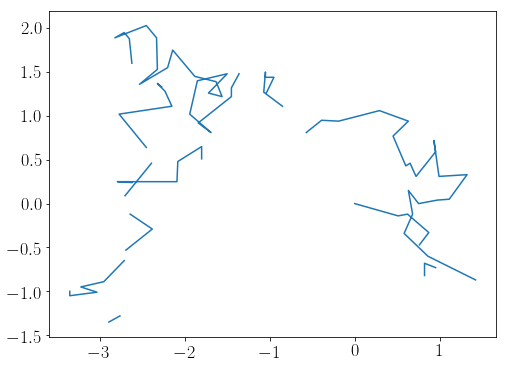

In [221]:
path_data_ori = np.genfromtxt('extracted_data.txt',delimiter=',')
path_initial = [path_data_ori[0,:],]*len(path_data_ori[:,0])
path_data_centered = path_data_ori - path_initial

particle_num = 36
xpos = 2*particle_num 
ypos = 2*particle_num+1

plt.plot(path_data_centered[:,xpos],path_data_centered[:,ypos])

In [222]:
max_2 = 100
max_grad = 4

def dist_array(data):
    
    return_array = []
    
    for part in range(0,int(len(data[0,:])/2)):
        xpos = 2*part
        ypos = 2*part+1
        
        x,y = path_data_centered[:,xpos],path_data_centered[:,ypos]
                
        dist_2_array = x**2+y**2
        
        if max(dist_2_array) < max_2 and max(np.gradient(np.sqrt(dist_2_array))) < max_grad:
            return_array.append(dist_2_array)
        
    return return_array
        
     
r2_array = dist_array(path_data_centered)
expect_r2_array = np.nanmean(r2_array,axis=0)
time_array = np.linspace(0,100./10.15,101)

In [223]:
def num_array(data):
    
    return_array = []
    
    for entry in data:
        values = entry[~np.isnan(entry)]
        return_array.append(int(len(values)/2))
        
    return return_array

number_array = np.array(num_array(path_data_centered))

In [224]:
import pandas as pd
# Conducting weighted linear least squares fit
# put x and y into a pandas DataFrame, and the weights into a Series
ws = pd.DataFrame({
    'x': time_array,
    'y': expect_r2_array
})

wls_fit = sm.wls('y ~ x -1', data=ws,weights = np.sqrt(number_array)).fit()

In [225]:
wls_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.874e+04
Date:                Fri, 16 Mar 2018   Prob (F-statistic):          7.98e-125
Time:                        11:47:41   Log-Likelihood:                -68.878
No. Observations:                 101   AIC:                             139.8
Df Residuals:                     100   BIC:                             142.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.4373      0.008    169.529      0.000       1.421       1.454
==============================================================================
Omnibus:                        7.430   Durbin-Watson:                   0.613
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               11.114
Skew:                          -0.273   Prob(JB):                      0.00386
Kurtosis:                       4.530   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [226]:
slope = wls_fit.params[0]
slope_uncer = np.sqrt(wls_fit.cov_params()['x'][0])
print('Self Diffusion, DM: %.2E +- %.0E m^2/s'%(Decimal(slope/4*(10**(-6))**2),Decimal(slope_uncer/4*(10**(-6))**2)))

Self Diffusion, DM: 3.59E-13 +- 2E-15 m^2/s


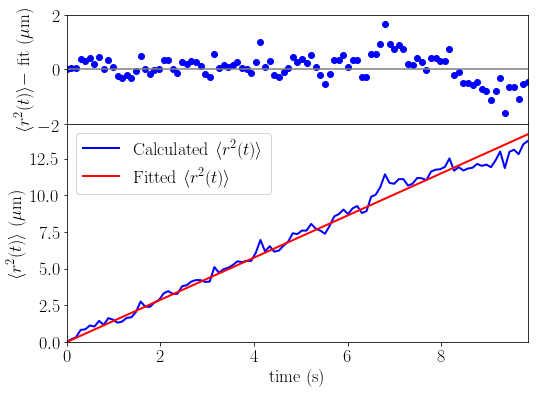

In [227]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2],hspace=0.0) 
ax0 = plt.subplot(gs[0])
ax0.plot([0,10],[0,0],color='grey')
ax0.scatter(time_array,expect_r2_array-slope*time_array,color='b')
ax0.set_xlim([0,100/10.15])
ax0.set_ylim([-2,2])
ax0.set_xticklabels([])
ax0.set_ylabel(r'$\langle r^2(t)\rangle-$ fit $(\mu \text{m})$')

ax1 = plt.subplot(gs[1])
cal = ax1.plot(time_array,expect_r2_array,color='b',linewidth=2,label=r'Calculated $\langle r^2(t)\rangle$')
exp = ax1.plot(time_array,slope*time_array,color='r',linewidth=2,label=r'Fitted $\langle r^2(t)\rangle$')
ax1.set_ylim(0,slope*time_array[-1]*1.05)
ax1.set_xlim([0,100/10.15])

ax1.legend(loc='best')

ax1.set_ylabel(r'$\langle r^2(t)\rangle$ $(\mu \text{m})$')
ax1.set_xlabel(r'time (s)')

plt.tight_layout()

In [228]:
t = 80*10**(-6)
u_t = 5*10**(-6)
a = 0.63*10**(-6)
u_a = 0.015*10**(-6)
delta = slope*(10**(-6))**2
u_delta = slope_uncer*(10**(-6))**2

D = delta/4*(1-9*a/(4*t))**(-1)

#u_D calculation
a_comp = u_a*(-9)/(4*t)*(1-(9*a)/(4*t))**(-2)*delta/4
t_comp = u_t*(-9*a)/(4*t**2)*(1-(9*a)/(4*t))**(-2)*delta/4
delta_comp = u_delta*(1-(9*a)/(4*t))**(-1)/4

u_D = (a_comp**2+t_comp**2+delta_comp**2)**(1/2)

print('The diffusion coefficient (D not DM): %.2E +- %.0E'%(Decimal(D),Decimal(u_D)))

The diffusion coefficient (D not DM): 3.66E-13 +- 2E-15


In [229]:
T_array = np.array([10,15,20,25,30]) + 273.15
eta_array = np.array([1308,1139,1003,891,798])*10**(-6)

T = 20+273
u_T = 1

In [230]:
eta_func = interp1d(T_array,eta_array)

eta = float(eta_func(T))
u_eta = eta - float(eta_func(T+u_T))
print('Viscocity: %0.2E +- %.0E    m^2/s' % (Decimal(eta),Decimal(u_eta)))

Viscocity: 1.01E-03 +- 2E-05    m^2/s


In [231]:
kb = 6*np.pi*eta*a/T*D

# u_kb calculation
T_comp = u_T*6*np.pi*eta*a*D/(T**2)
eta_comp = u_eta*6*np.pi*a*D/T
a_comp = u_a*6*np.pi*eta*D/T
D_comp = u_D*6*np.pi*eta*a/T

u_kb = np.sqrt(T_comp**2+eta_comp**2+a_comp**2+D_comp**2)

print('Boltzmann\'s constant: %.2E +- %.0E     m^2 kg /s^2 K'%(Decimal(kb), Decimal(u_kb)))

Boltzmann's constant: 1.49E-23 +- 5E-25     m^2 kg /s^2 K


In [232]:
R = 8.314

Na = R*T/(6*np.pi*eta*a*D)

# u_Na calculation
T_comp = u_T*R/(6*np.pi*eta*D*a)
eta_comp = u_eta*R*T/(6*np.pi*eta**(2)*D*a)
a_comp = u_a*R*T/(6*np.pi*eta*D*a**(2))
D_comp = u_D*R*T/(6*np.pi*eta*D**(2)*a)

u_Na = np.sqrt(T_comp**2+eta_comp**2+a_comp**2+D_comp**2)

print('Avogrado\'s number: %.2E +- %.2E    atoms/mole'%(Decimal(Na),Decimal(u_Na)))

Avogrado's number: 5.57E+23 +- 1.88E+22    atoms/mole


In [233]:
cutoff = 1

def prob_array(data, times):
    
    x_array = []
    y_array = []
    
    if type(times) != float:
        times= times[cutoff:]
    
    for part in range(0,int(len(data[0,:])/2)):
        xpos = 2*part
        ypos = 2*part+1
        
        x,y = path_data_centered[:,xpos],path_data_centered[:,ypos]
        
        x = x[cutoff:]
        y = y[cutoff:]
        
        dist_2_array = x**2+y**2
        
        xs = x*1./np.sqrt(times)
        ys = y*1./np.sqrt(times)
        
        #if max(dist_2_array) < max_2 and max(np.gradient(np.sqrt(dist_2_array))) < max_grad:
        x_array.extend(xs)
        y_array.extend(ys)

    return x_array, y_array

x_list, y_list = prob_array(path_data_centered,time_array)
x_list = np.array(x_list)
y_list = np.array(y_list)

In [234]:
x_list = x_list[~np.isnan(x_list)]
y_list = y_list[~np.isnan(y_list)]

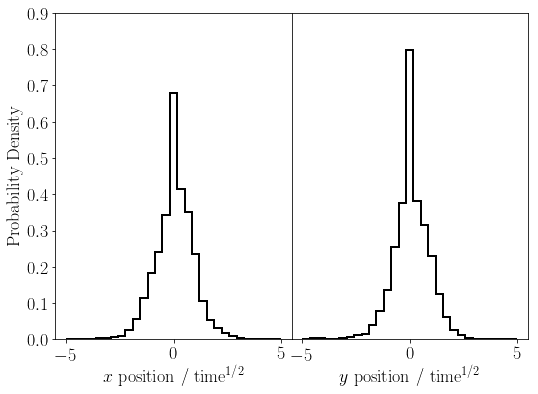

In [235]:
nb = 30

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 2, height_ratios=[1],wspace=0.0) 
ax0 = plt.subplot(gs[0])
ax0.hist(x_list,bins=np.linspace(-5,5,nb),normed=True,color='k',histtype='step',linewidth=2)
ax0.set_ylim(0,0.9)
ax0.set_xlabel(r'$x$ position / time$^{1/2}$')

ax1 = plt.subplot(gs[1])
ax1.hist(y_list,bins=np.linspace(-5,5,nb),normed=True,color='k',histtype='step',linewidth=2)
ax0.set_ylabel(r'Probability Density')
ax1.set_yticklabels([])
ax1.set_ylim(0,0.9)
ax1.set_xlabel(r'$y$ position / time$^{1/2}$')
ax1.yaxis.set_major_locator(plt.NullLocator())

plt.tight_layout()

### Definitions of Gaussian Fitting Functions

In [236]:
# Create a function which returns a Gaussian (normal) distribution.
def double_gauss(x, *p):
    a1, mu1, s1, a2, mu2, s2 = p
    y = a1*np.exp(-np.power((x - mu1), 2.)/(2. * s1**2.)) + a2*np.exp(-np.power((x - mu2), 2.)/(2. * s2**2.))

    return y

# Create a function which returns a Gaussian (normal) distribution.
def gauss(x, *p):
    a, b, c  = p
    y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.))

    return y

## Ignore middle bins

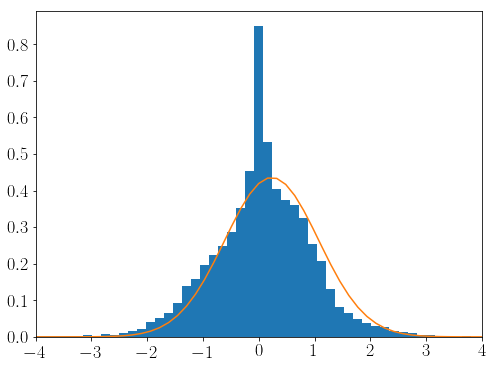

In [237]:
nb = 100

nc,xc,q = (plt.hist(x_list,bins=np.linspace(-8,8,nb),normed=True))
xc += 8/nb

xc_n = xc[np.where(np.abs(xc) >0.5)][1:]
nc_n = nc[np.where(np.abs(xc[1:]) >0.5)]

p_initial = [0.25,0,3]

popt, pcov = curve_fit(gauss, xc_n,nc_n, p0=p_initial)
perr = np.sqrt(np.diag(pcov))

# Generate y-data based on the fit.
y_fit = gauss(xc, *popt)
plt.plot(xc,y_fit)
plt.xlim(-4,4)
plt.show()

In [238]:
DM = popt[-1]**2/2*(10**(-6))**2
u_DM = perr[-1]*popt[-1]*(10**(-6))**2
print('Self Diffusion, DM: %.2E +- %.0E m^2/s'%(Decimal(DM),Decimal(u_DM)))

Self Diffusion, DM: 3.54E-13 +- 8E-15 m^2/s


## Double Gaussian Fit

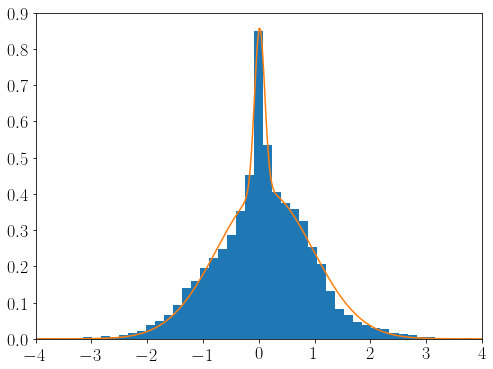

In [239]:
nc,xc,q = (plt.hist(x_list,bins=np.linspace(-8,8,nb),normed=True))
xc += 8/nb

p_initial = [0.25,0,1.8,1.5,0,0.1]

popt, pcov = curve_fit(double_gauss, xc[:-1],nc, p0=p_initial)
perr = np.sqrt(np.diag(pcov))
y_fit_d = double_gauss(np.linspace(-10,10,1000), *popt)

plt.plot(np.linspace(-10,10,1000),y_fit_d)
plt.xlim(-4,4)
plt.show()

Text(0.5,1,'Data with the peak removed')

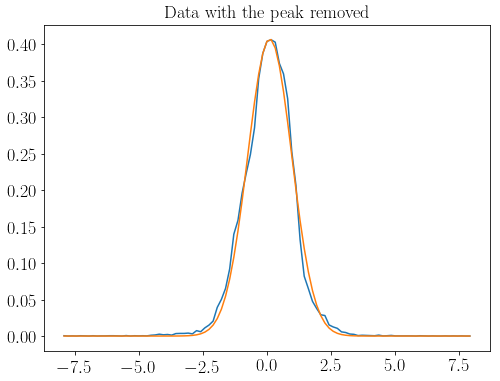

In [240]:
y_fit_peak = gauss(xc[:-1], *popt[-3:])
y_fit_brown = gauss(xc[:-1], *popt[:3])
anti_peak_data = nc - y_fit_peak
plt.plot(xc[:-1],anti_peak_data)
plt.plot(xc[:-1],y_fit_brown)
plt.title(r'Data with the peak removed')

In [241]:
DM = popt[2]**2/2*(10**(-6))**2
u_DM = perr[2]*popt[-1]*(10**(-6))**2
print('Self Diffusion, DM: %.2E +- %.0E m^2/s'%(Decimal(DM),Decimal(u_DM)))

Self Diffusion, DM: 3.70E-13 +- 1E-15 m^2/s


### Adding Criteria to Remove Data

In [242]:
cutoff = 1

def prob_array_extra(data, times):
    
    x_array = []
    y_array = []
    
    if type(times) != float:
        times= times[cutoff:]
    
    for part in range(0,int(len(data[0,:])/2)):
        xpos = 2*part
        ypos = 2*part+1
        
        x,y = path_data_centered[:,xpos],path_data_centered[:,ypos]
        
        x = x[cutoff:]
        y = y[cutoff:]
        
        dist_2_array = x**2+y**2
        
        xs = x*1./np.sqrt(times)
        ys = y*1./np.sqrt(times)
        
        if max(dist_2_array) < max_2 and max(np.gradient(np.sqrt(dist_2_array))) < max_grad and len(np.where(abs(xs) == 0.0)[0]) == 0 and len(np.where(ys == 0.0)[0]) == 0:
            x_array.extend(xs)
            y_array.extend(ys)
    
    x_array = np.array(x_array)
    y_array = np.array(y_array)
    
    x_array = x_array[~np.isnan(x_array)]
    y_array = y_array[~np.isnan(y_array)]
    
    return x_array, y_array

x_list_ex, y_list_ex = prob_array_extra(path_data_centered,time_array)
x_list_ex = np.array(x_list_ex)
y_list_ex = np.array(y_list_ex)

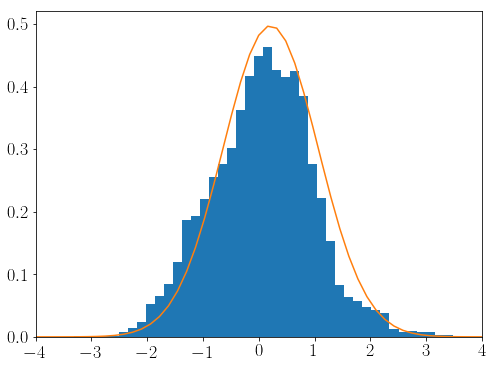

In [243]:
nb = 100

nc,xc,q = (plt.hist(x_list_ex,bins=np.linspace(-8,8,nb),normed=True))
xc += 8/nb

xc_n = xc[np.where(np.abs(xc) >0.5)][1:]
nc_n = nc[np.where(np.abs(xc[1:]) >0.5)]

p_initial = [0.25,0,3]

popt, pcov = curve_fit(gauss, xc_n,nc_n, p0=p_initial)
perr = np.sqrt(np.diag(pcov))

# Generate y-data based on the fit.
y_fit = gauss(xc, *popt)
plt.plot(xc,y_fit)
plt.xlim(-4,4)
plt.show()

In [244]:
DM = popt[-1]**2/2*(10**(-6))**2
u_DM = perr[-1]*popt[-1]*(10**(-6))**2
print('Self Diffusion, DM: %.2E +- %.0E m^2/s'%(Decimal(DM),Decimal(u_DM)))

Self Diffusion, DM: 3.64E-13 +- 1E-14 m^2/s
